<a href="https://colab.research.google.com/github/lanyu0322/pedestrian_firstdraft_figures/blob/master/4_population_fit_constraint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.ndimage.filters import uniform_filter as uf

# -- install geopandas
try:
  import geopandas as gp
except:
  !pip install geopandas

     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 10.9MB 16.8MB/s 
     |████████████████████████████████| 14.7MB 317kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# -- read in the weekday counts
camera_fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", 
                            "cams_ft_wd.feather")
camera = pd.read_feather(camera_fname)

# -- read in the average weekend counts
fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", 
                     "avg_weekend_ts.feather")
weekend = uf(pd.read_feather(fname)["avg_counts"].values, 8)

# -- extract just the counts from weekdays
camarr = camera.drop(columns=["cam_id", "lat", "lon"]).values

In [ ]:
# # -- standardized data
# camarr_m = camarr.mean(axis=1, keepdims=True)
# camarr_std = camarr.std(axis=1, keepdims=True)
# camarr_st = (camarr - camarr_m) / (camarr_std + (camarr_std == 0))


# fit 4-pop model

In [ ]:
# -- define gaussian
def gauss(xarr, x0, sig, scl):
  """ Create a 1D Gaussian """
  
  amp = scl / (sig * np.sqrt(2.0 * np.pi))
  val = -0.5 * ((xarr - x0) / sig)**2
  
  return amp * np.exp(val)


# -- define the model
def pop_model(param, xval):

  # -- determine which model is being used from length of param array
  nparam = len(param)

  # -- 3 population model
  if nparam == 10:
    m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, off = param
    wamp = 0.0

  # -- 4 population model
  elif nparam == 11:
    m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = param

  # -- ill-defined param array
  else:
    print("Nparam must be 10 (3pop) or 11 (4pop) model!")
    return None

  model = gauss(xval, m1, sd1, scl1) + gauss(xval, m2, sd2, scl2) + \
    gauss(xval, m3, sd3, scl3) + wamp * wendvals + off

  return model


# -- define model error
def res(param, xval, yval):

  return yval - pop_model(param, xval)

In [ ]:
#4-population fit for average weekday counts for all cameras

# -- set inital guess
avgs  = [35, 47, 70] 
sigs  = [3, 3, 3]
scls  = [5, 5, 5]
off   = [0.5]
wamp = [6]
param = avgs + sigs + scls + wamp + off

# -- set fit and model parameters and 
wendvals = weekend
xval_final = np.arange(96)
bounds_lo = [24., 44., 64., 2.0, 2.0, 2.0, 0, 0, 0, 0, -np.inf]
bounds_hi = [44., 64., 80., 8., 8., 8., np.inf, np.inf, np.inf, np.inf, np.inf]

# -- optimize
plsq4 = [least_squares(res, param, bounds=(bounds_lo, bounds_hi), 
                       args=(xval_final, camarr[i])) for i in range(len(camarr))]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

KeyboardInterrupt: ignored

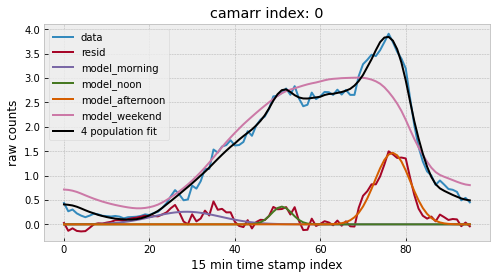

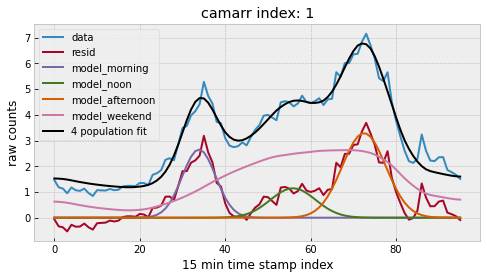

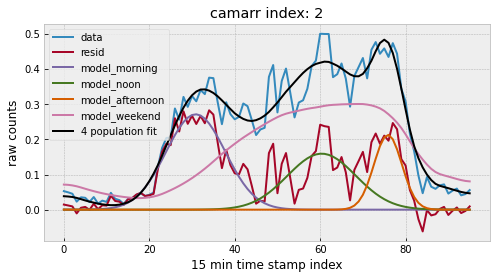

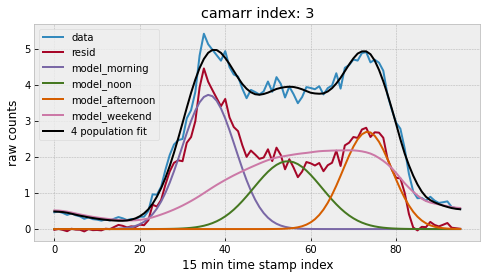

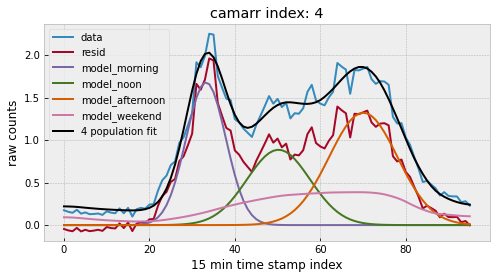

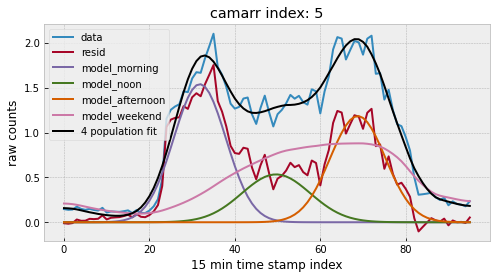

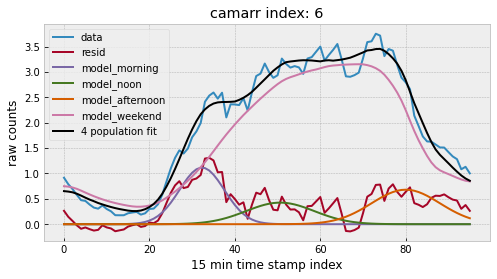

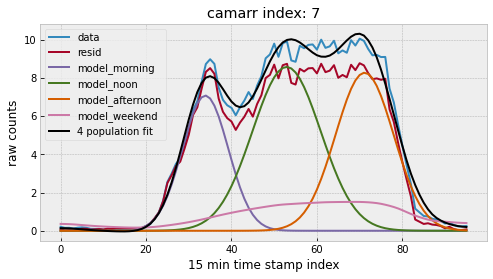

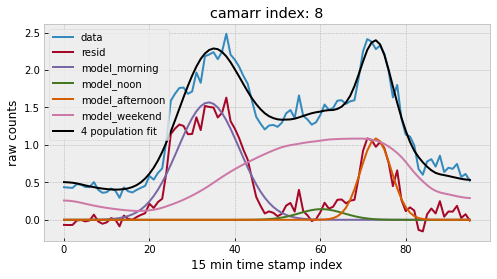

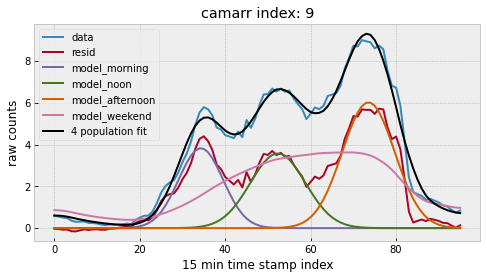

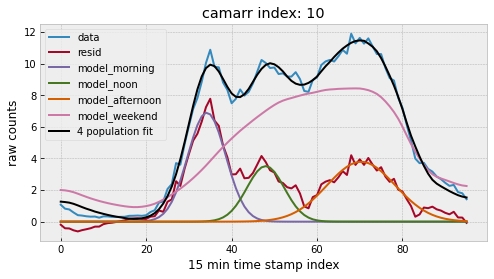

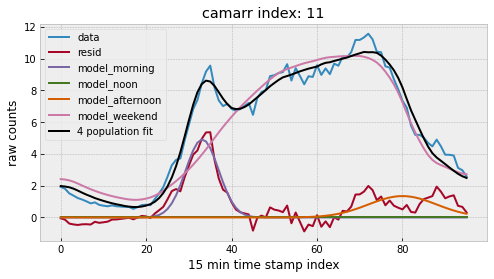

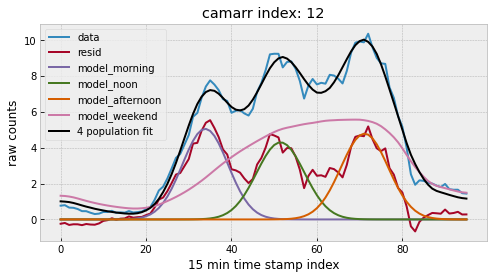

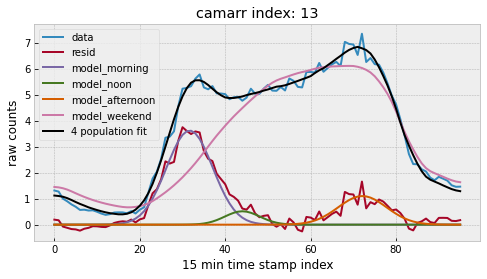

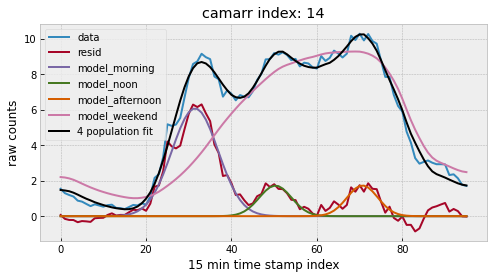

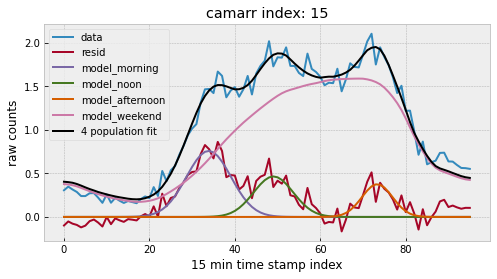

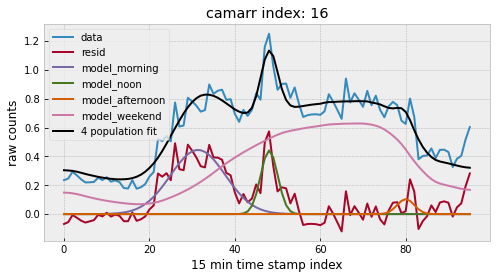

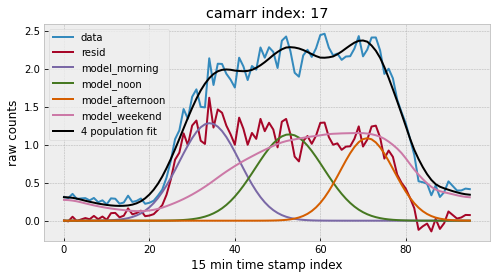

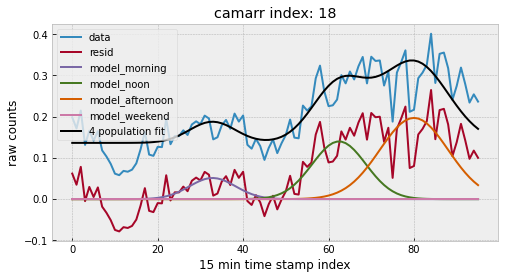

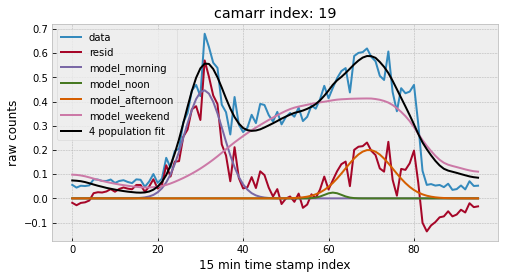

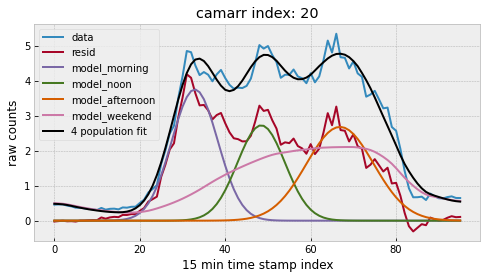

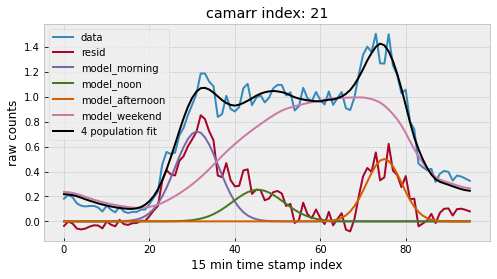

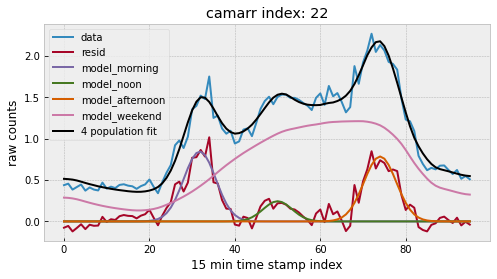

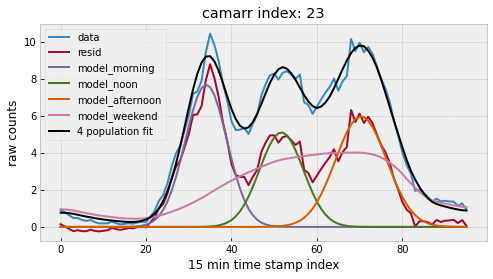

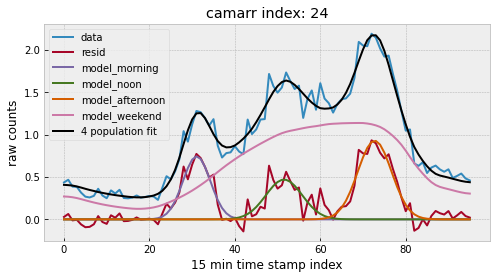

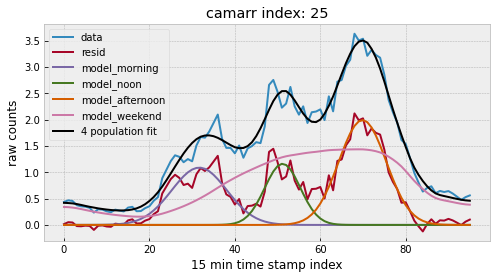

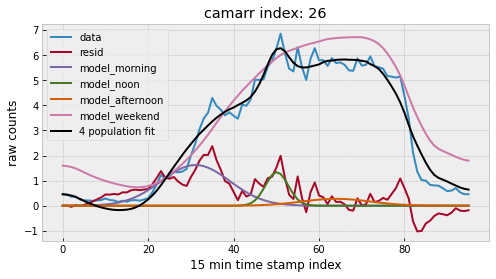

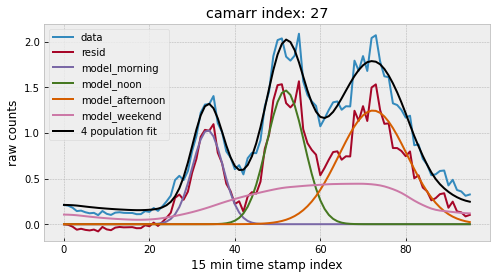

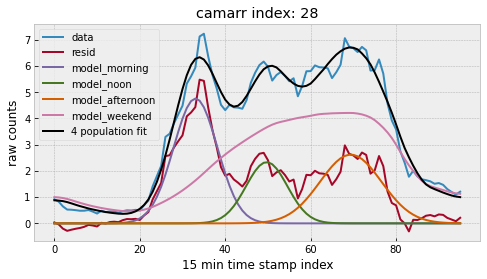

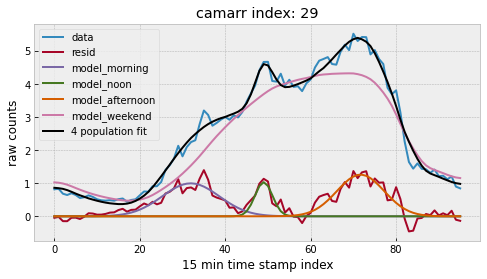

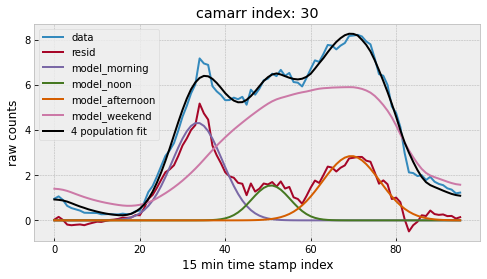

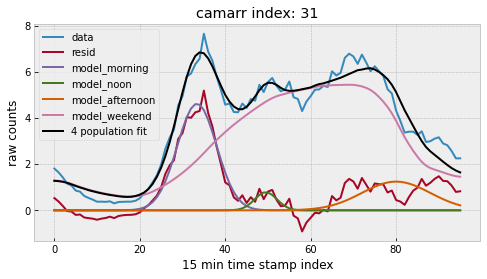

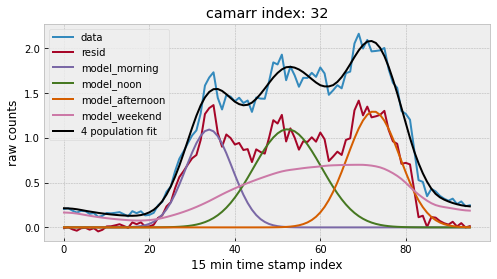

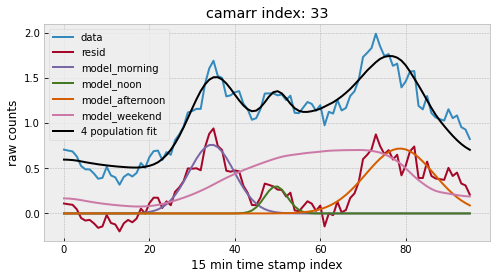

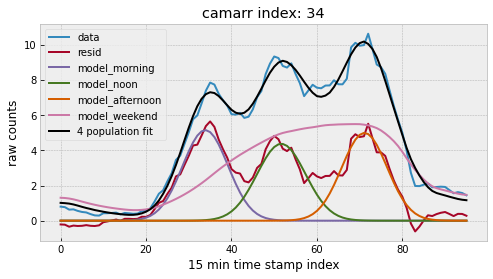

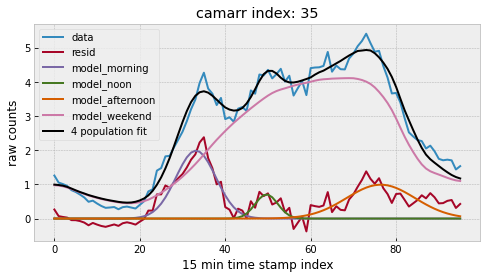

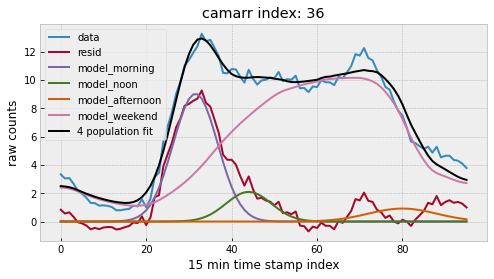

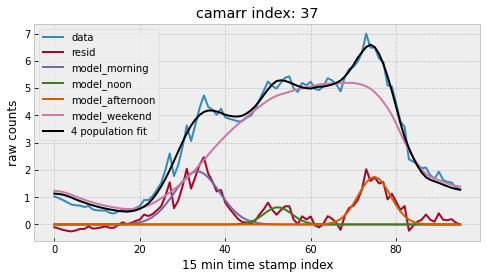

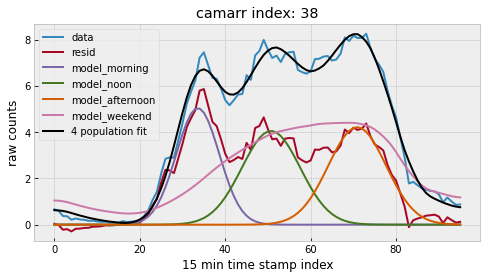

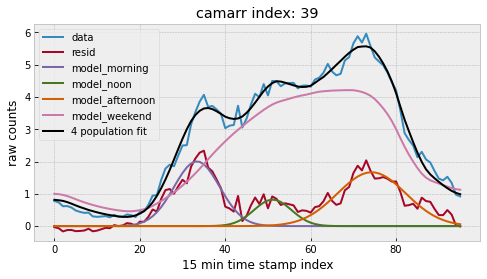

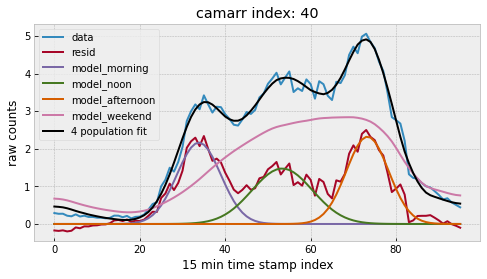

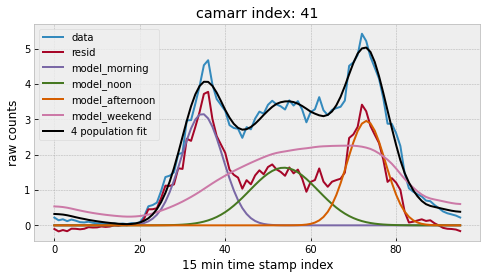

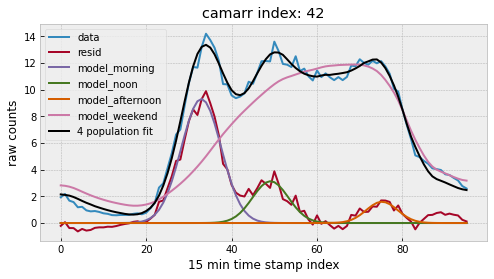

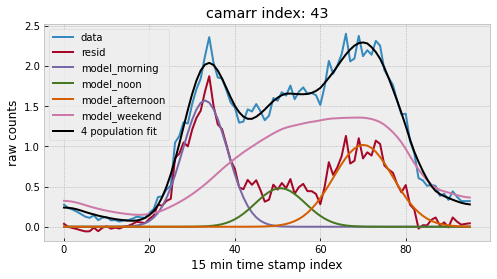

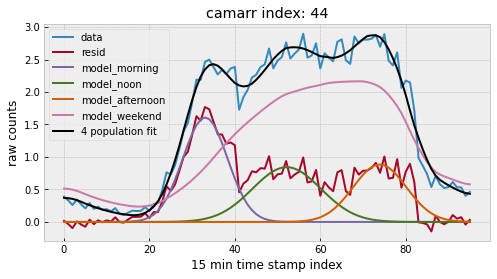

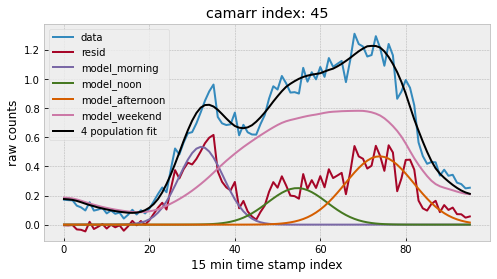

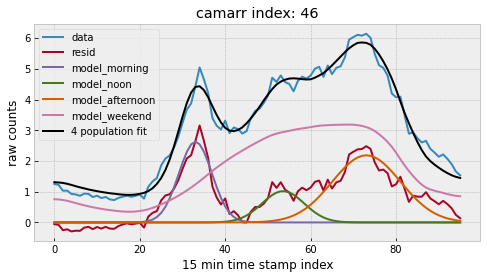

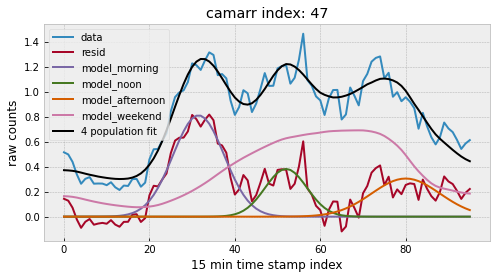

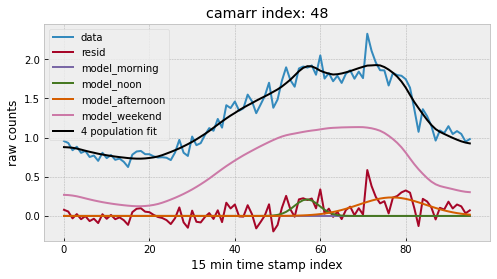

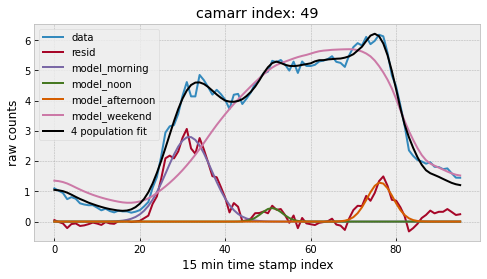

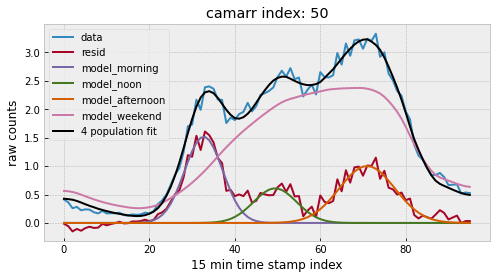

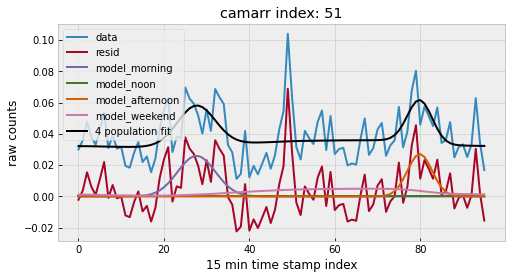

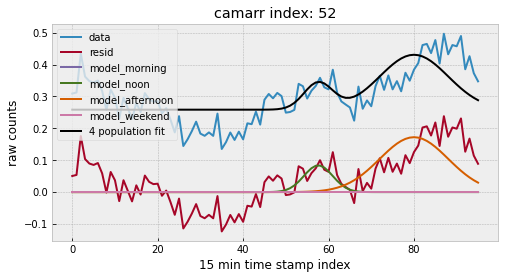

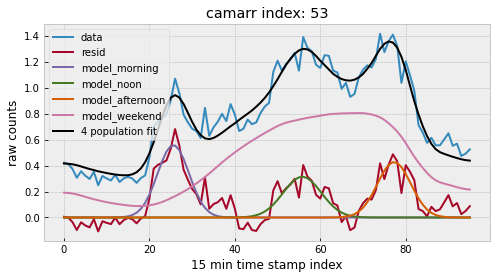

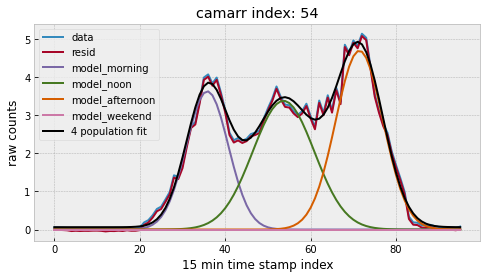

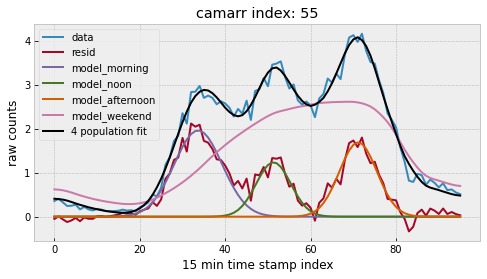

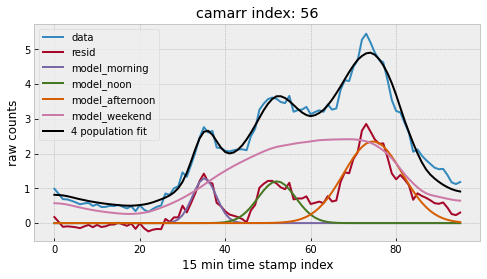

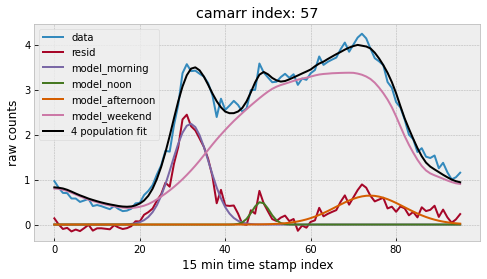

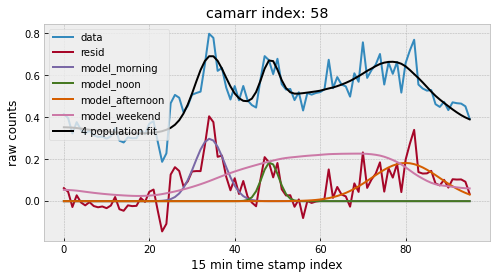

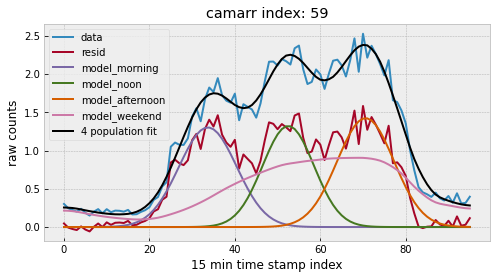

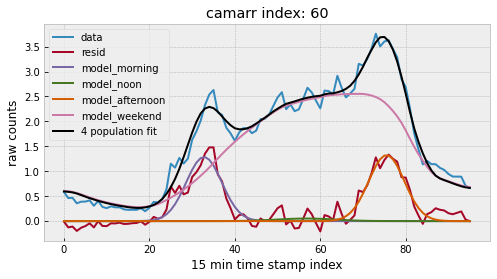

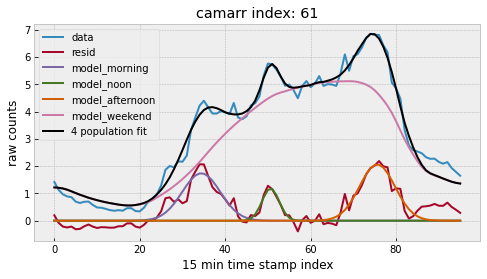

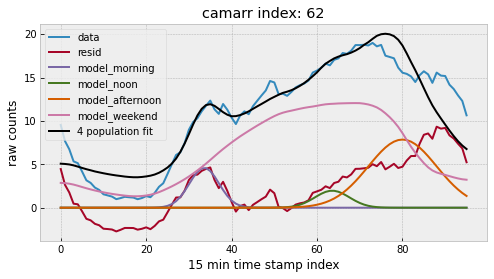

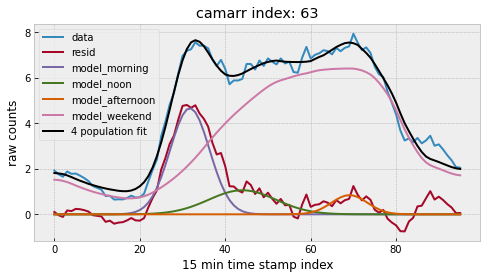

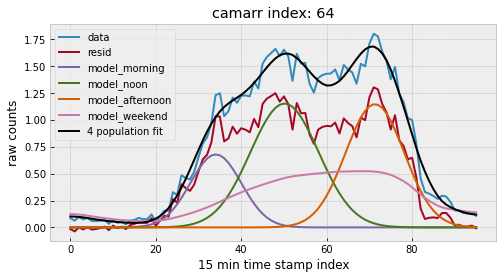

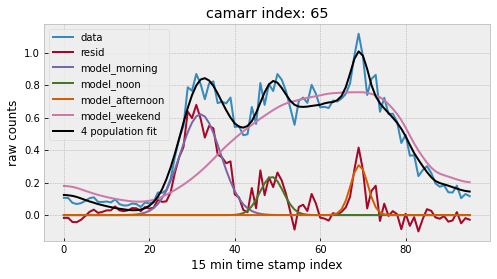

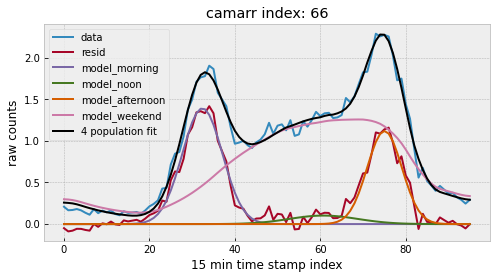

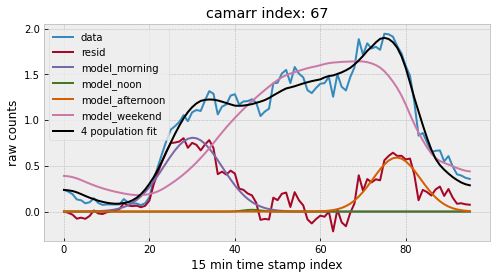

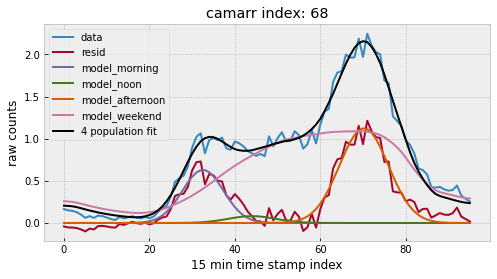

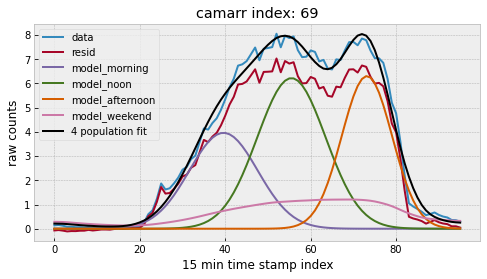

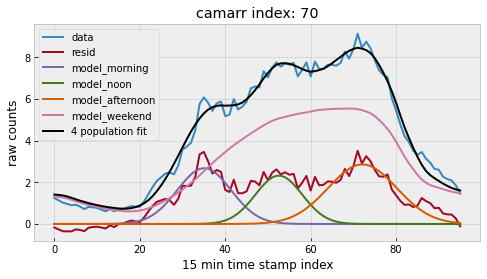

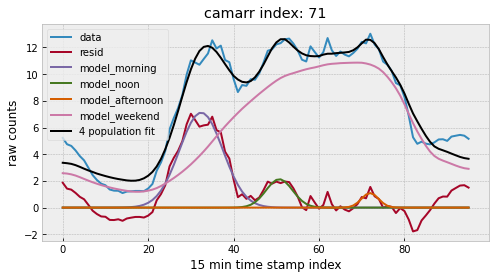

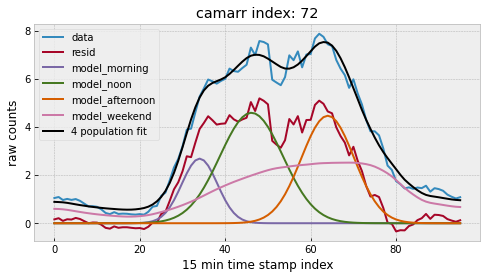

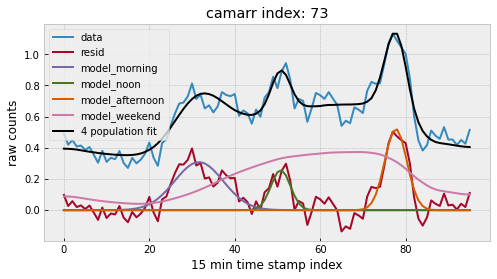

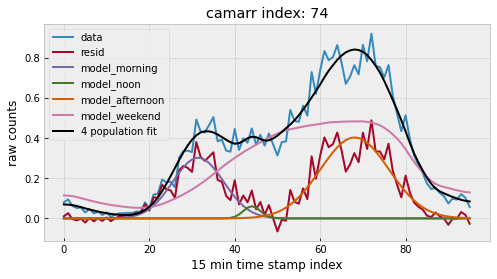

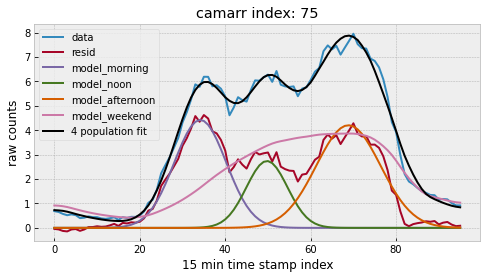

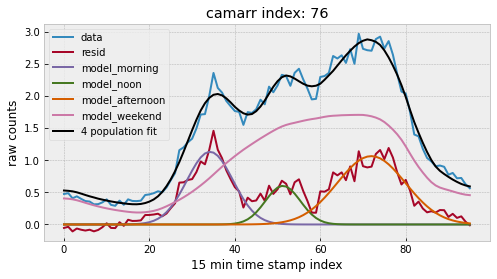

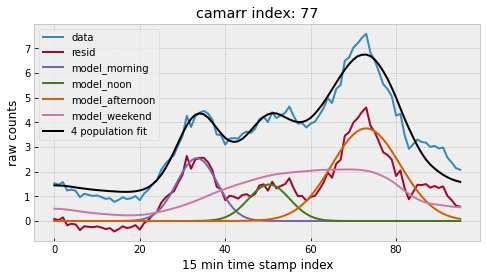

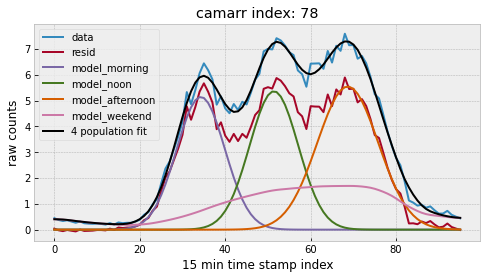

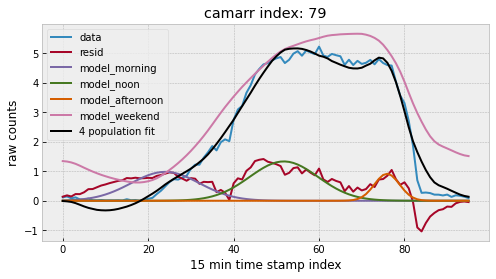

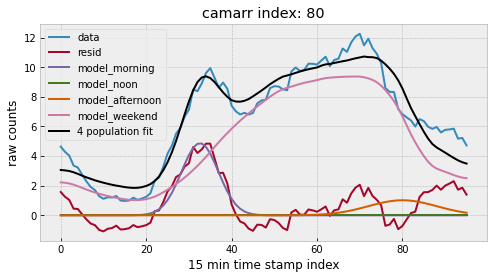

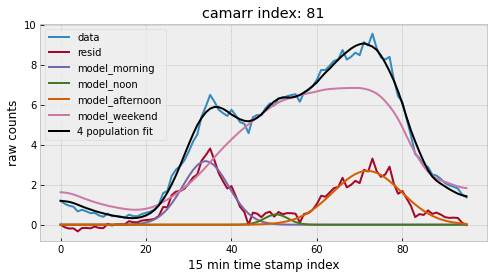

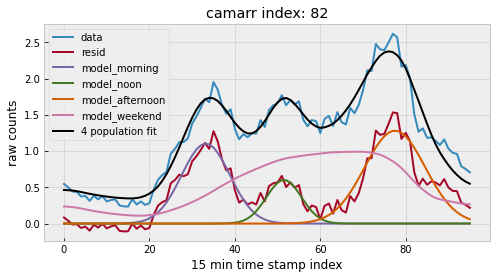

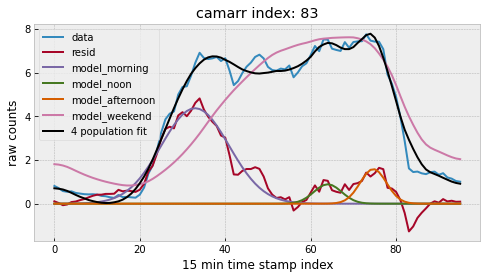

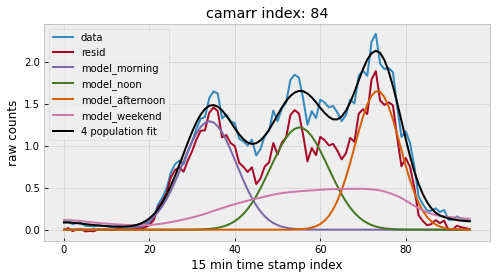

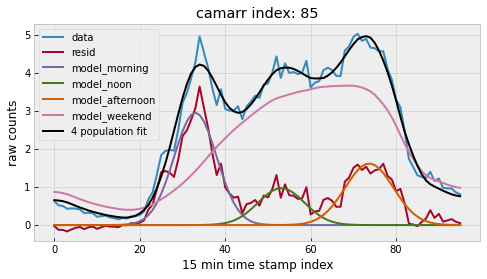

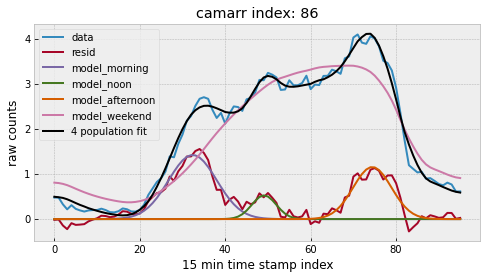

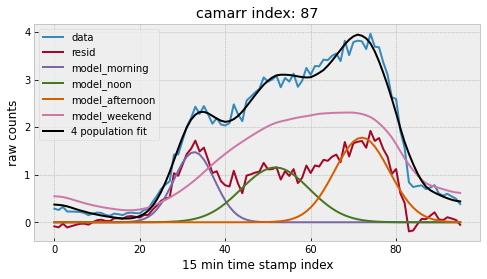

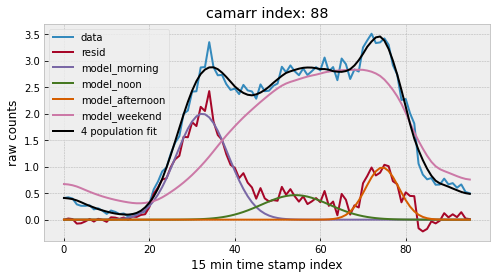

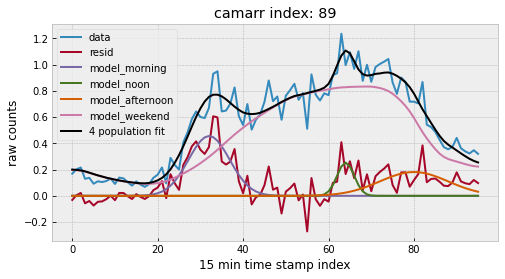

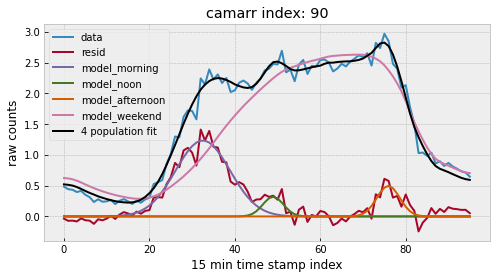

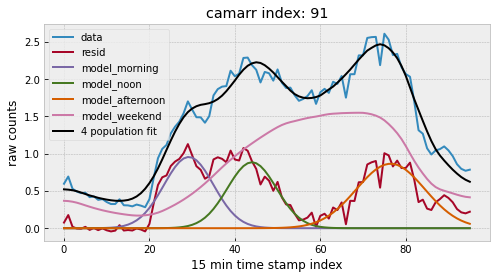

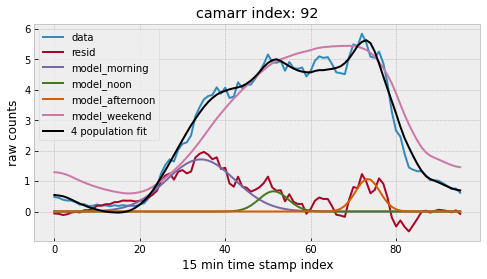

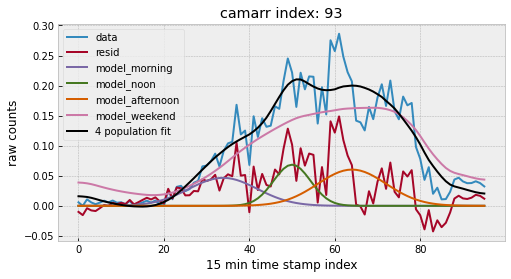

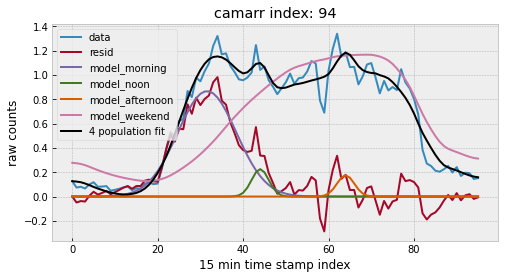

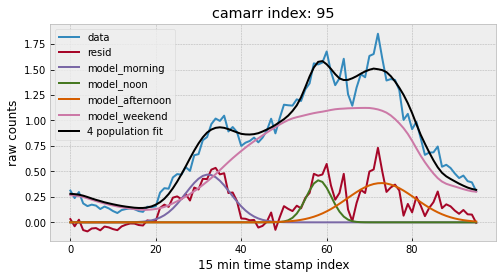

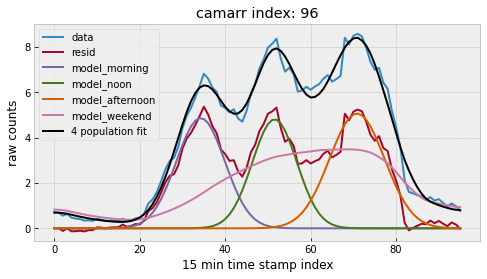

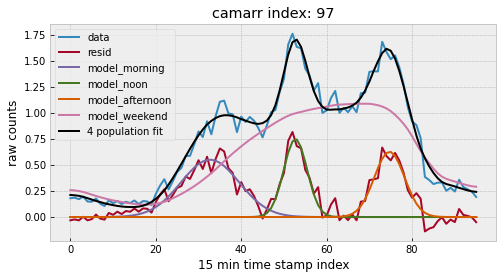

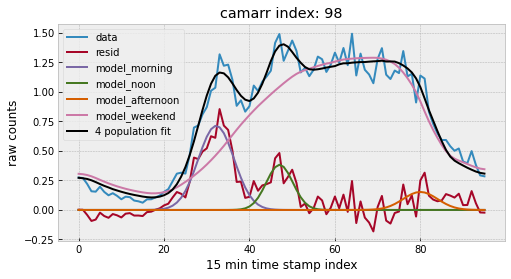

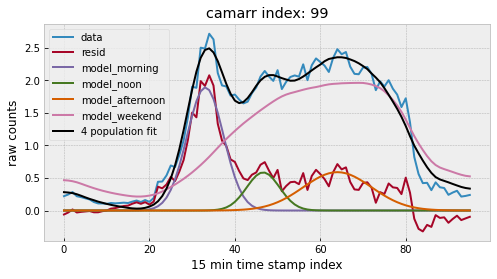

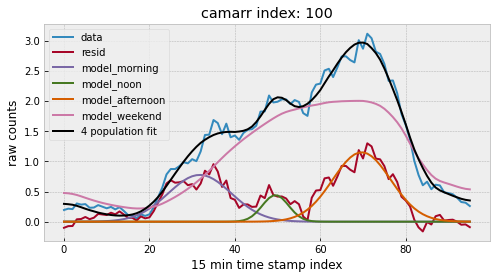

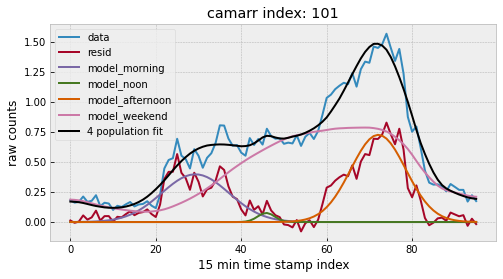

<Figure size 576x288 with 0 Axes>

In [ ]:
#plot model 
for i in range(len(plsq4)):
  m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = plsq4[i]["x"]
  model1 = gauss(xval_final, m1, sd1, scl1)
  model2 = gauss(xval_final, m2, sd2, scl2)
  model3 = gauss(xval_final, m3, sd3, scl3)
  pdat = camarr[i]
  resid = pdat - wamp * wendvals - off
  model4 = wamp * wendvals
  model5 = camarr[i] - wamp * wendvals
  off = off
  plt.style.use("bmh")
  fig, ax = plt.subplots(figsize=[8, 4])
  ax.plot(xval_final, camarr[i], label="data")

  ax.plot(resid, label="resid")
  ax.plot(model1, label="model_morning")
  ax.plot(model2, label="model_noon")
  ax.plot(model3, label="model_afternoon")
  ax.plot(uf(wamp * wendvals), label="model_weekend")
  ax.plot(model1 + model2 + model3 + wamp * wendvals + off, "k", 
          label="4 population fit")

  ax.set_title("camarr index: {0}".format(i))
  ax.set_xlabel("15 min time stamp index")
  ax.set_ylabel("raw counts")
  ax.legend()
  fig.show()

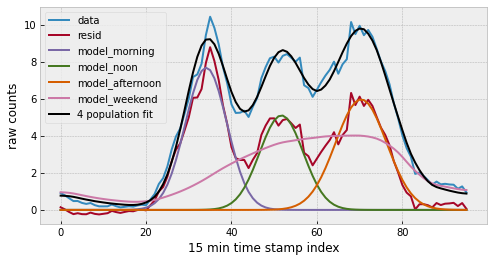

In [ ]:
#plot model 
#for i in range(len(plsq)):
m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = plsq4[23]["x"]
model1 = gauss(xval_final, m1, sd1, scl1)
model2 = gauss(xval_final, m2, sd2, scl2)
model3 = gauss(xval_final, m3, sd3, scl3)
pdat = camarr[23]
resid = pdat - wamp * wendvals - off
model4 = wamp * wendvals
model5 = camarr[23] - wamp * wendvals
off = off
plt.style.use("bmh")
fig, ax = plt.subplots(figsize=[8, 4])
ax.plot(xval_final, camarr[23], label="data")

ax.plot(resid, label="resid")
ax.plot(model1, label="model_morning")
ax.plot(model2, label="model_noon")
ax.plot(model3, label="model_afternoon")
ax.plot(uf(wamp * wendvals), label="model_weekend")
ax.plot(model1 + model2 + model3 + wamp * wendvals + off, "k", 
          label="4 population fit")

#ax.set_title("camarr index: {0}".format(i))
ax.set_xlabel("15 min time stamp index")
ax.set_ylabel("raw counts")
ax.legend()
fig.show()

outfile = os.path.join("drive", "My Drive", "lwir", "output", "4 pop fit 23.png")
fig.savefig(outfile)

In [ ]:
m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = plsq4[41]["x"]
model1 = gauss(xval_final, m1, sd1, scl1)
model2 = gauss(xval_final, m2, sd2, scl2)
model3 = gauss(xval_final, m3, sd3, scl3)
pdat = camarr[41]
resid = pdat - wamp * wendvals - off
model4 = wamp * wendvals
model5 = camarr[41] - wamp * wendvals
off = off
plt.style.use("bmh")
fig, ax = plt.subplots(figsize=[8, 4])
ax.plot(xval_final, camarr[41], label="data")

ax.plot(resid, label="resid")
ax.plot(model1, label="model_morning")
ax.plot(model2, label="model_noon")
ax.plot(model3, label="model_afternoon")
ax.plot(uf(wamp * wendvals), label="model_weekend")
ax.plot(model1 + model2 + model3 + wamp * wendvals + off, "k", 
          label="4 population fit")

#ax.set_title("camarr index: {0}".format(i))
ax.set_xlabel("15 min time stamp index")
ax.set_ylabel("raw counts")
ax.legend()
fig.show()

outfile = os.path.join("drive", "My Drive", "lwir", "output", "4 pop fit 41.png")
fig.savefig(outfile)

In [ ]:
m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = plsq4[82]["x"]
model1 = gauss(xval_final, m1, sd1, scl1)
model2 = gauss(xval_final, m2, sd2, scl2)
model3 = gauss(xval_final, m3, sd3, scl3)
pdat = camarr[82]
resid = pdat - wamp * wendvals - off
model4 = wamp * wendvals
model5 = camarr[82] - wamp * wendvals
off = off
plt.style.use("bmh")
fig, ax = plt.subplots(figsize=[8, 4])
ax.plot(xval_final, camarr[82], label="data")

ax.plot(resid, label="resid")
ax.plot(model1, label="model_morning")
ax.plot(model2, label="model_noon")
ax.plot(model3, label="model_afternoon")
ax.plot(uf(wamp * wendvals), label="model_weekend")
ax.plot(model1 + model2 + model3 + wamp * wendvals + off, "k", 
          label="4 population fit")

#ax.set_title("camarr index: {0}".format(i))
ax.set_xlabel("15 min time stamp index")
ax.set_ylabel("raw counts")
ax.legend()
fig.show()

outfile = os.path.join("drive", "My Drive", "lwir", "output", "4 pop fit 82.png")
fig.savefig(outfile)

In [ ]:
m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = plsq4[115]["x"]
model1 = gauss(xval_final, m1, sd1, scl1)
model2 = gauss(xval_final, m2, sd2, scl2)
model3 = gauss(xval_final, m3, sd3, scl3)
pdat = camarr[115]
resid = pdat - wamp * wendvals - off
model4 = wamp * wendvals
model5 = camarr[115] - wamp * wendvals
off = off
plt.style.use("bmh")
fig, ax = plt.subplots(figsize=[8, 4])
ax.plot(xval_final, camarr[115], label="data")

ax.plot(resid, label="resid")
ax.plot(model1, label="model_morning")
ax.plot(model2, label="model_noon")
ax.plot(model3, label="model_afternoon")
ax.plot(uf(wamp * wendvals), label="model_weekend")
ax.plot(model1 + model2 + model3 + wamp * wendvals + off, "k", 
          label="4 population fit")

#ax.set_title("camarr index: {0}".format(i))
ax.set_xlabel("15 min time stamp index")
ax.set_ylabel("raw counts")
ax.legend()
fig.show()
ax.legend(loc='upper left')
outfile = os.path.join("drive", "My Drive", "lwir", "output", "4 pop fit 115.png")
fig.savefig(outfile)

In [ ]:
m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = plsq4[114]["x"]
model1 = gauss(xval_final, m1, sd1, scl1)
model2 = gauss(xval_final, m2, sd2, scl2)
model3 = gauss(xval_final, m3, sd3, scl3)
pdat = camarr[114]
resid = pdat - wamp * wendvals - off
model4 = wamp * wendvals
model5 = camarr[114] - wamp * wendvals
off = off
plt.style.use("bmh")
fig, ax = plt.subplots(figsize=[8, 4])
ax.plot(xval_final, camarr[114], label="data")

ax.plot(resid, label="resid")
ax.plot(model1, label="model_morning")
ax.plot(model2, label="model_noon")
ax.plot(model3, label="model_afternoon")
ax.plot(uf(wamp * wendvals), label="model_weekend")
ax.plot(model1 + model2 + model3 + wamp * wendvals + off, "k", 
          label="4 population fit")

#ax.set_title("camarr index: {0}".format(i))
ax.set_xlabel("15 min time stamp index")
ax.set_ylabel("raw counts")
ax.legend()
fig.show()
ax.legend(loc='upper left')
outfile = os.path.join("drive", "My Drive", "lwir", "output", "4 pop fit 114.png")
fig.savefig(outfile)

In [ ]:
m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = plsq4[51]["x"]
model1 = gauss(xval_final, m1, sd1, scl1)
model2 = gauss(xval_final, m2, sd2, scl2)
model3 = gauss(xval_final, m3, sd3, scl3)
pdat = camarr[51]
resid = pdat - wamp * wendvals - off
model4 = wamp * wendvals
model5 = camarr[51] - wamp * wendvals
off = off
plt.style.use("bmh")
fig, ax = plt.subplots(figsize=[8, 4])
ax.plot(xval_final, camarr[51], label="data")

ax.plot(resid, label="resid")
ax.plot(model1, label="model_morning")
ax.plot(model2, label="model_noon")
ax.plot(model3, label="model_afternoon")
ax.plot(uf(wamp * wendvals), label="model_weekend")
ax.plot(model1 + model2 + model3 + wamp * wendvals + off, "k", 
          label="4 population fit")

#ax.set_title("camarr index: {0}".format(i))
ax.set_xlabel("15 min time stamp index")
ax.set_ylabel("raw counts")
ax.legend()
fig.show()
ax.legend(loc='upper left')
outfile = os.path.join("drive", "My Drive", "lwir", "output", "4 pop fit 51.png")
fig.savefig(outfile)

In [ ]:
m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = plsq4[106]["x"]
model1 = gauss(xval_final, m1, sd1, scl1)
model2 = gauss(xval_final, m2, sd2, scl2)
model3 = gauss(xval_final, m3, sd3, scl3)
pdat = camarr[106]
resid = pdat - wamp * wendvals - off
model4 = wamp * wendvals
model5 = camarr[106] - wamp * wendvals
off = off
plt.style.use("bmh")
fig, ax = plt.subplots(figsize=[8, 4])
ax.plot(xval_final, camarr[106], label="data")

ax.plot(resid, label="resid")
ax.plot(model1, label="model_morning")
ax.plot(model2, label="model_noon")
ax.plot(model3, label="model_afternoon")
ax.plot(uf(wamp * wendvals), label="model_weekend")
ax.plot(model1 + model2 + model3 + wamp * wendvals + off, "k", 
          label="4 population fit")

#ax.set_title("camarr index: {0}".format(i))
ax.set_xlabel("15 min time stamp index")
ax.set_ylabel("raw counts")
ax.legend()
fig.show()
ax.legend(loc='upper left')

outfile = os.path.join("drive", "My Drive", "lwir", "output", "4 pop fit 106.png")
fig.savefig(outfile)

In [ ]:
# -- read in the number of restaurants
rname = "/content/drive/My Drive/lwir/data/4_pop_fit/restaurant.csv"
rstrant = pd.read_csv(rname)

# -- read in the park area with 500 feet
pname = "/content/drive/My Drive/lwir/data/4_pop_fit/parkarea.csv"
parkarea = pd.read_csv(pname)

# -- read in number of workers and residents with 500 ft (from LEHD)
wname = "/content/drive/My Drive/lwir/data/4_pop_fit/wr_manhattan.csv"
wr_manhattan = pd.read_csv(wname)

In [ ]:
# -- put fit results into DataFrame
result_vals = pd.DataFrame(plsq4)["x"].values
pardf = pd.DataFrame(np.vstack(result_vals), 
                     columns=["m1", "m2", "m3", "sd1", "sd2", "sd3", 
                              "scl1", "scl2", "scl3", "wamp", "off"])

# -- add lat/lon
pardf["lat"] = camera["lat"]
pardf["lon"] = camera["lon"]

# -- add number of restaurants and park area (within 500 ft)
pardf["rstrant"] = rstrant
pardf["parkarea"] = parkarea

# -- calculate sratio and f
pardf["sratio"] = pardf["scl2"] / (0.5 * (pardf["scl1"] + pardf["scl3"]))
pardf["w_manhattan"] = wr_manhattan["working_manhattan"]
pardf["r_manhattan"] = wr_manhattan["residents_manhattan"]
pardf["f"] = pardf["sratio"] * (pardf["r_manhattan"] / pardf["w_manhattan"] + 1)

In [ ]:
# -- set indices of cameras that don't have 3-peak behavior
bind = [0, 5, 8, 11, 13, 19, 36, 45, 48, 51, 52, 60, 62, 63, 66, 67, 68, 69, 
        74, 79, 80, 81, 89, 93, 94, 98, 99, 103, 104, 106, 110, 113, 114, 115, 
        121, 125, 137, 138, 139, 146, 151]
pardf = pardf[~pardf.index.isin(bind)].copy()

In [ ]:
camera_id = camera[camera.index.isin(bind)].copy()
camera_id

cam_id        lat        lon  ...         93         94         95
0       172  40.716623 -73.999186  ...   0.492537   0.542913   0.451564
5       176  40.758440 -73.964939  ...   0.197312   0.177916   0.234890
8       165  40.745339 -73.974895  ...   0.571949   0.612072   0.522844
11      170  40.748818 -73.987470  ...   3.122761   2.977028   2.578201
13      173  40.754084 -73.983908  ...   1.514847   1.456061   1.461926
19      360  40.800426 -73.931551  ...   0.070723   0.051173   0.052372
36      501  40.750151 -73.990560  ...   4.296752   4.090078   3.777615
45      537  40.783304 -73.944662  ...   0.278814   0.249267   0.253733
48      545  40.756295 -74.004507  ...   1.046650   0.948680   0.980818
51      795  40.796969 -73.929317  ...   0.062757   0.034104   0.016862
52      547  40.747712 -74.007897  ...   0.426111   0.372825   0.347259
60      845  40.733504 -73.987239  ...   0.891402   0.709286   0.663978
62      899  40.756583 -73.986156  ...  12.937826  12.300733  10.643304
63      891  40.756691 -73.986476  ...   2.372103   2.077957   2.048094
66      934  40.770142 -73.957381  ...   0.291511   0.246481   0.291680
67      940  40.761501 -73.960542  ...   0.393830   0.368915   0.356459
68      970  40.785302 -73.969353  ...   0.325611   0.288251   0.253666
69      175  40.711776 -74.004722  ...   0.360173   0.350599   0.290693
74      248  40.850354 -73.940604  ...   0.121190   0.103128   0.056452
79      452  40.709046 -74.000735  ...   0.169550   0.138270   0.091251
80      475  40.755092 -73.986740  ...   5.173242   5.226931   4.716031
81      500  40.744396 -73.998113  ...   1.804091   1.504399   1.363930
89      847  40.848330 -73.930868  ...   0.322795   0.347849   0.320332
93      989  40.708272 -73.999488  ...   0.040811   0.037879   0.032258
94      177  40.761918 -73.961377  ...   0.192375   0.144470   0.151541
98      790  40.721437 -73.983838  ...   0.381036   0.292545   0.284818
99      791  40.719876 -73.978731  ...   0.213783   0.223633   0.238710
103     968  40.779481 -73.973578  ...   0.222239   0.178006   0.174389
104     969  40.782031 -73.971734  ...   0.529374   0.367535   0.264125
106     988  40.719655 -74.001842  ...   0.497752   0.420569   0.423118
110     517  40.715908 -73.988800  ...   0.422972   0.361238   0.266843
113     841  40.848657 -73.939207  ...   0.287879   0.390503   0.386232
114     291  40.795618 -73.976183  ...   0.023509   0.019344   0.031036
115     805  40.836133 -73.934883  ...   0.095064   0.091759   0.093451
121     446  40.710689 -73.984656  ...   0.183040   0.184262   0.146917
125     530  40.807980 -73.945472  ...   0.726795   0.698034   0.615708
137     932  40.820458 -73.936233  ...   0.138905   0.096872   0.093868
138     893  40.759040 -73.959443  ...   0.027370   0.013685   0.013441
139     909  40.771140 -73.963907  ...   0.239589   0.203519   0.224611
146     432  40.714802 -74.002790  ...   0.340056   0.291887   0.314106
151     715  40.729104 -74.010528  ...   0.473991   0.520674   0.455233

[41 rows x 99 columns]

In [ ]:
# -- write the reresults to a file
oname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "4pop_para.csv")
pardf.to_csv(oname, index=False)

In [ ]:
pardf

m1         m2         m3  ...   w_manhattan  r_manhattan         f
1    33.851518  55.863352  72.488416  ...  19861.575731   686.304649  0.460290
2    30.868148  60.345837  75.860100  ...   3871.237562  1712.178205  1.426865
3    36.113705  54.646821  73.313140  ...   3115.066002  1024.629008  1.031020
4    33.243216  50.212947  70.062318  ...    664.869474  2083.624285  2.936722
6    32.290951  50.613295  80.000000  ...    600.262988   114.241471  0.717580
..         ...        ...        ...  ...           ...          ...       ...
152  32.926378  57.179910  80.000000  ...   4789.079473   619.321194  0.529794
153  29.228765  48.527859  79.664739  ...    204.270486    33.049144  3.461102
154  33.755604  51.192035  72.037956  ...   4741.542367  1805.796279  0.652085
155  33.788794  51.541210  69.319872  ...  17701.876761   426.143228  1.163159
156  32.088927  52.561020  71.751482  ...   2454.558599  2195.678458  0.696004

[116 rows x 19 columns]